# MakeMore Implementation

Based on youtube video: https://www.youtube.com/watch?v=PaCmpygFfXo


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
%matplotlib inline

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

We want to create a language model that can predict the next item of anything (in this case chars).
For that we need a database (in this case names) and a way to encode the data for model training.

Note that at its core, this data generates a probability distribution (based on how likely a char is to follow another char).


In [121]:
# load the name data
with open("data/names.txt") as f:
    names = f.read().splitlines()

# print stats
print("Number of names: ", len(names))

# split names into bigrams
bigrams = {}
for name in names:
    ls = ["<T>"] + list(name.lower()) + ["<T>"]
    tpl = list(zip(ls, ls[1:]))
    for bigram in tpl:
        bigrams[bigram] = bigrams.get(bigram, 0) + 1

# print stats
print("Number of bigrams: ", len(bigrams))
print("Top 5 bigrams: ", sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[:5])
print("Lowest 5 bigrams: ", sorted(bigrams.items(), key=lambda x: x[1])[:5])

Number of names:  32033
Number of bigrams:  627
Top 5 bigrams:  [(('n', '<T>'), 6763), (('a', '<T>'), 6640), (('a', 'n'), 5438), (('<T>', 'a'), 4410), (('e', '<T>'), 3983)]
Lowest 5 bigrams:  [(('q', 'r'), 1), (('d', 'z'), 1), (('p', 'j'), 1), (('q', 'l'), 1), (('p', 'f'), 1)]


/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_14823/1606149063.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df = df.pivot('first', 'second', 'count')


<AxesSubplot: xlabel='second', ylabel='first'>

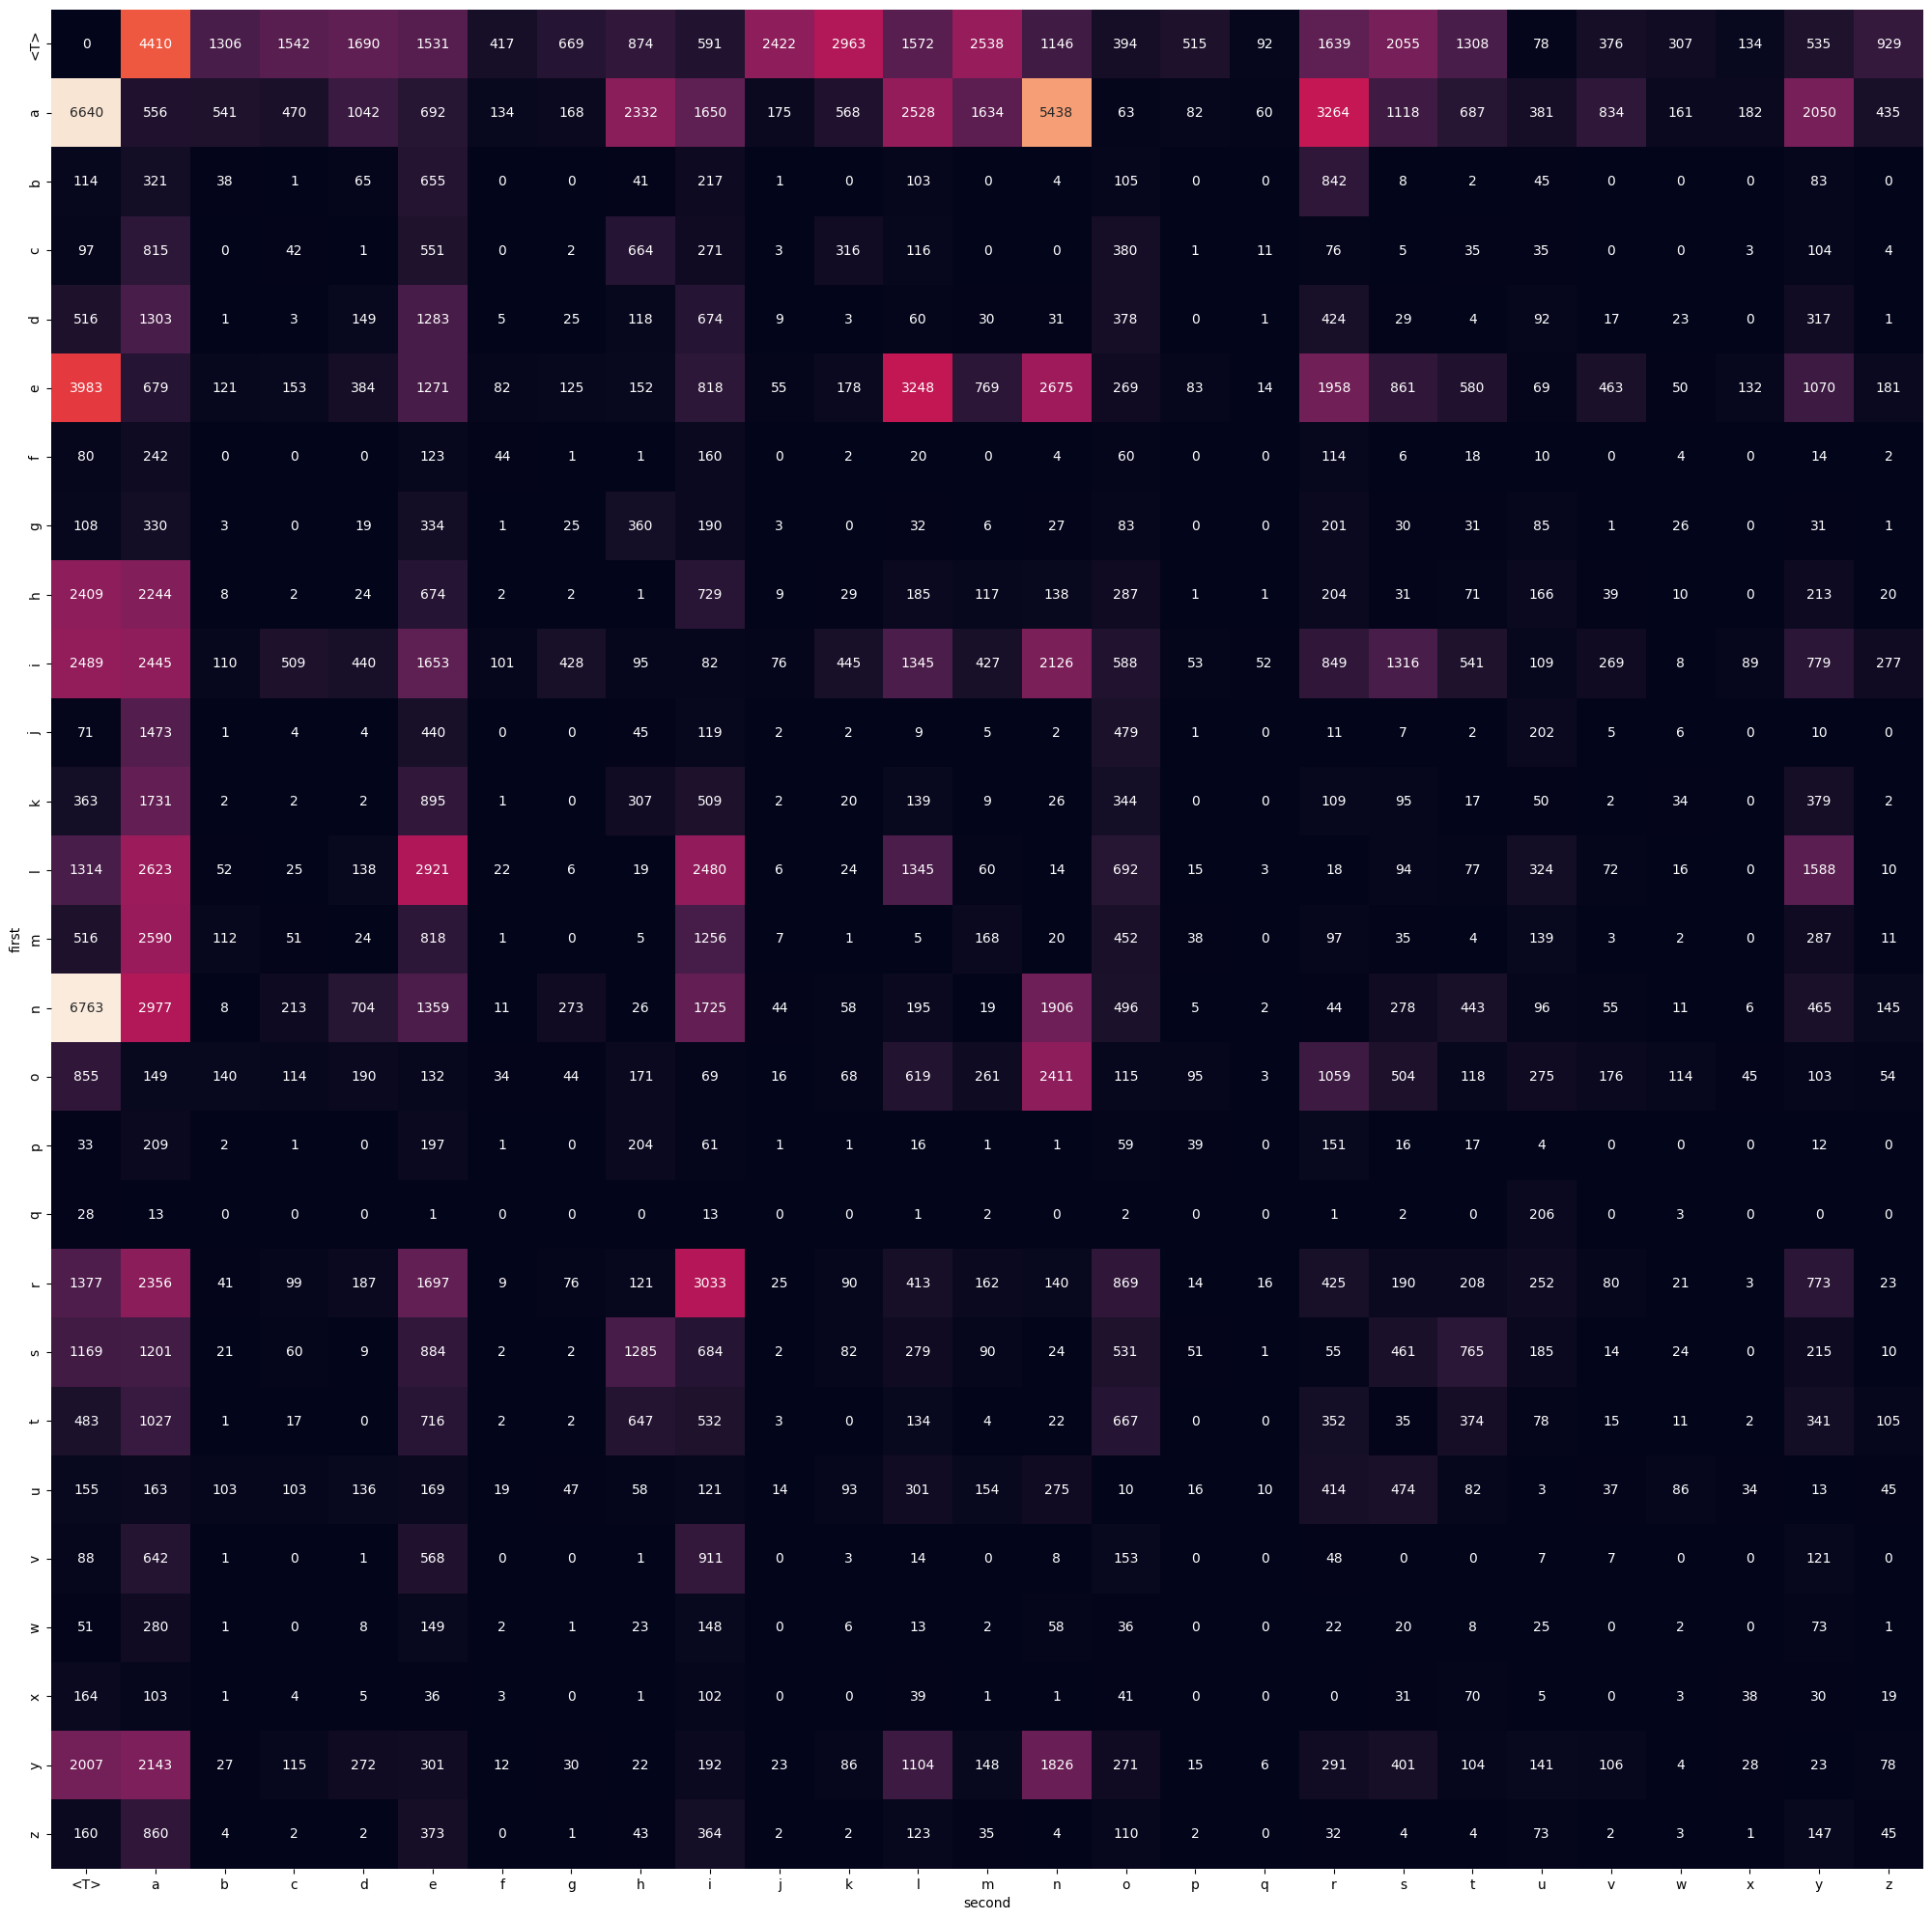

In [20]:
# visualize the data as a heatmap
df = pd.DataFrame(bigrams.items(), columns=["bigram", "count"])
df["first"] = df.bigram.apply(lambda x: x[0])
df["second"] = df.bigram.apply(lambda x: x[1])
df = df.pivot("first", "second", "count")
# format as int
df = df.fillna(0).astype(int)

# normalize the values
# df = df / df.max().sum()

plt.figure(figsize=(25, 25))
# sns.heatmap(df, annot=True, fmt='.2f', cbar=False)
sns.heatmap(df, annot=True, fmt="d", cbar=False)

Next step is to convert this into a pytorch tensor


<AxesSubplot: >

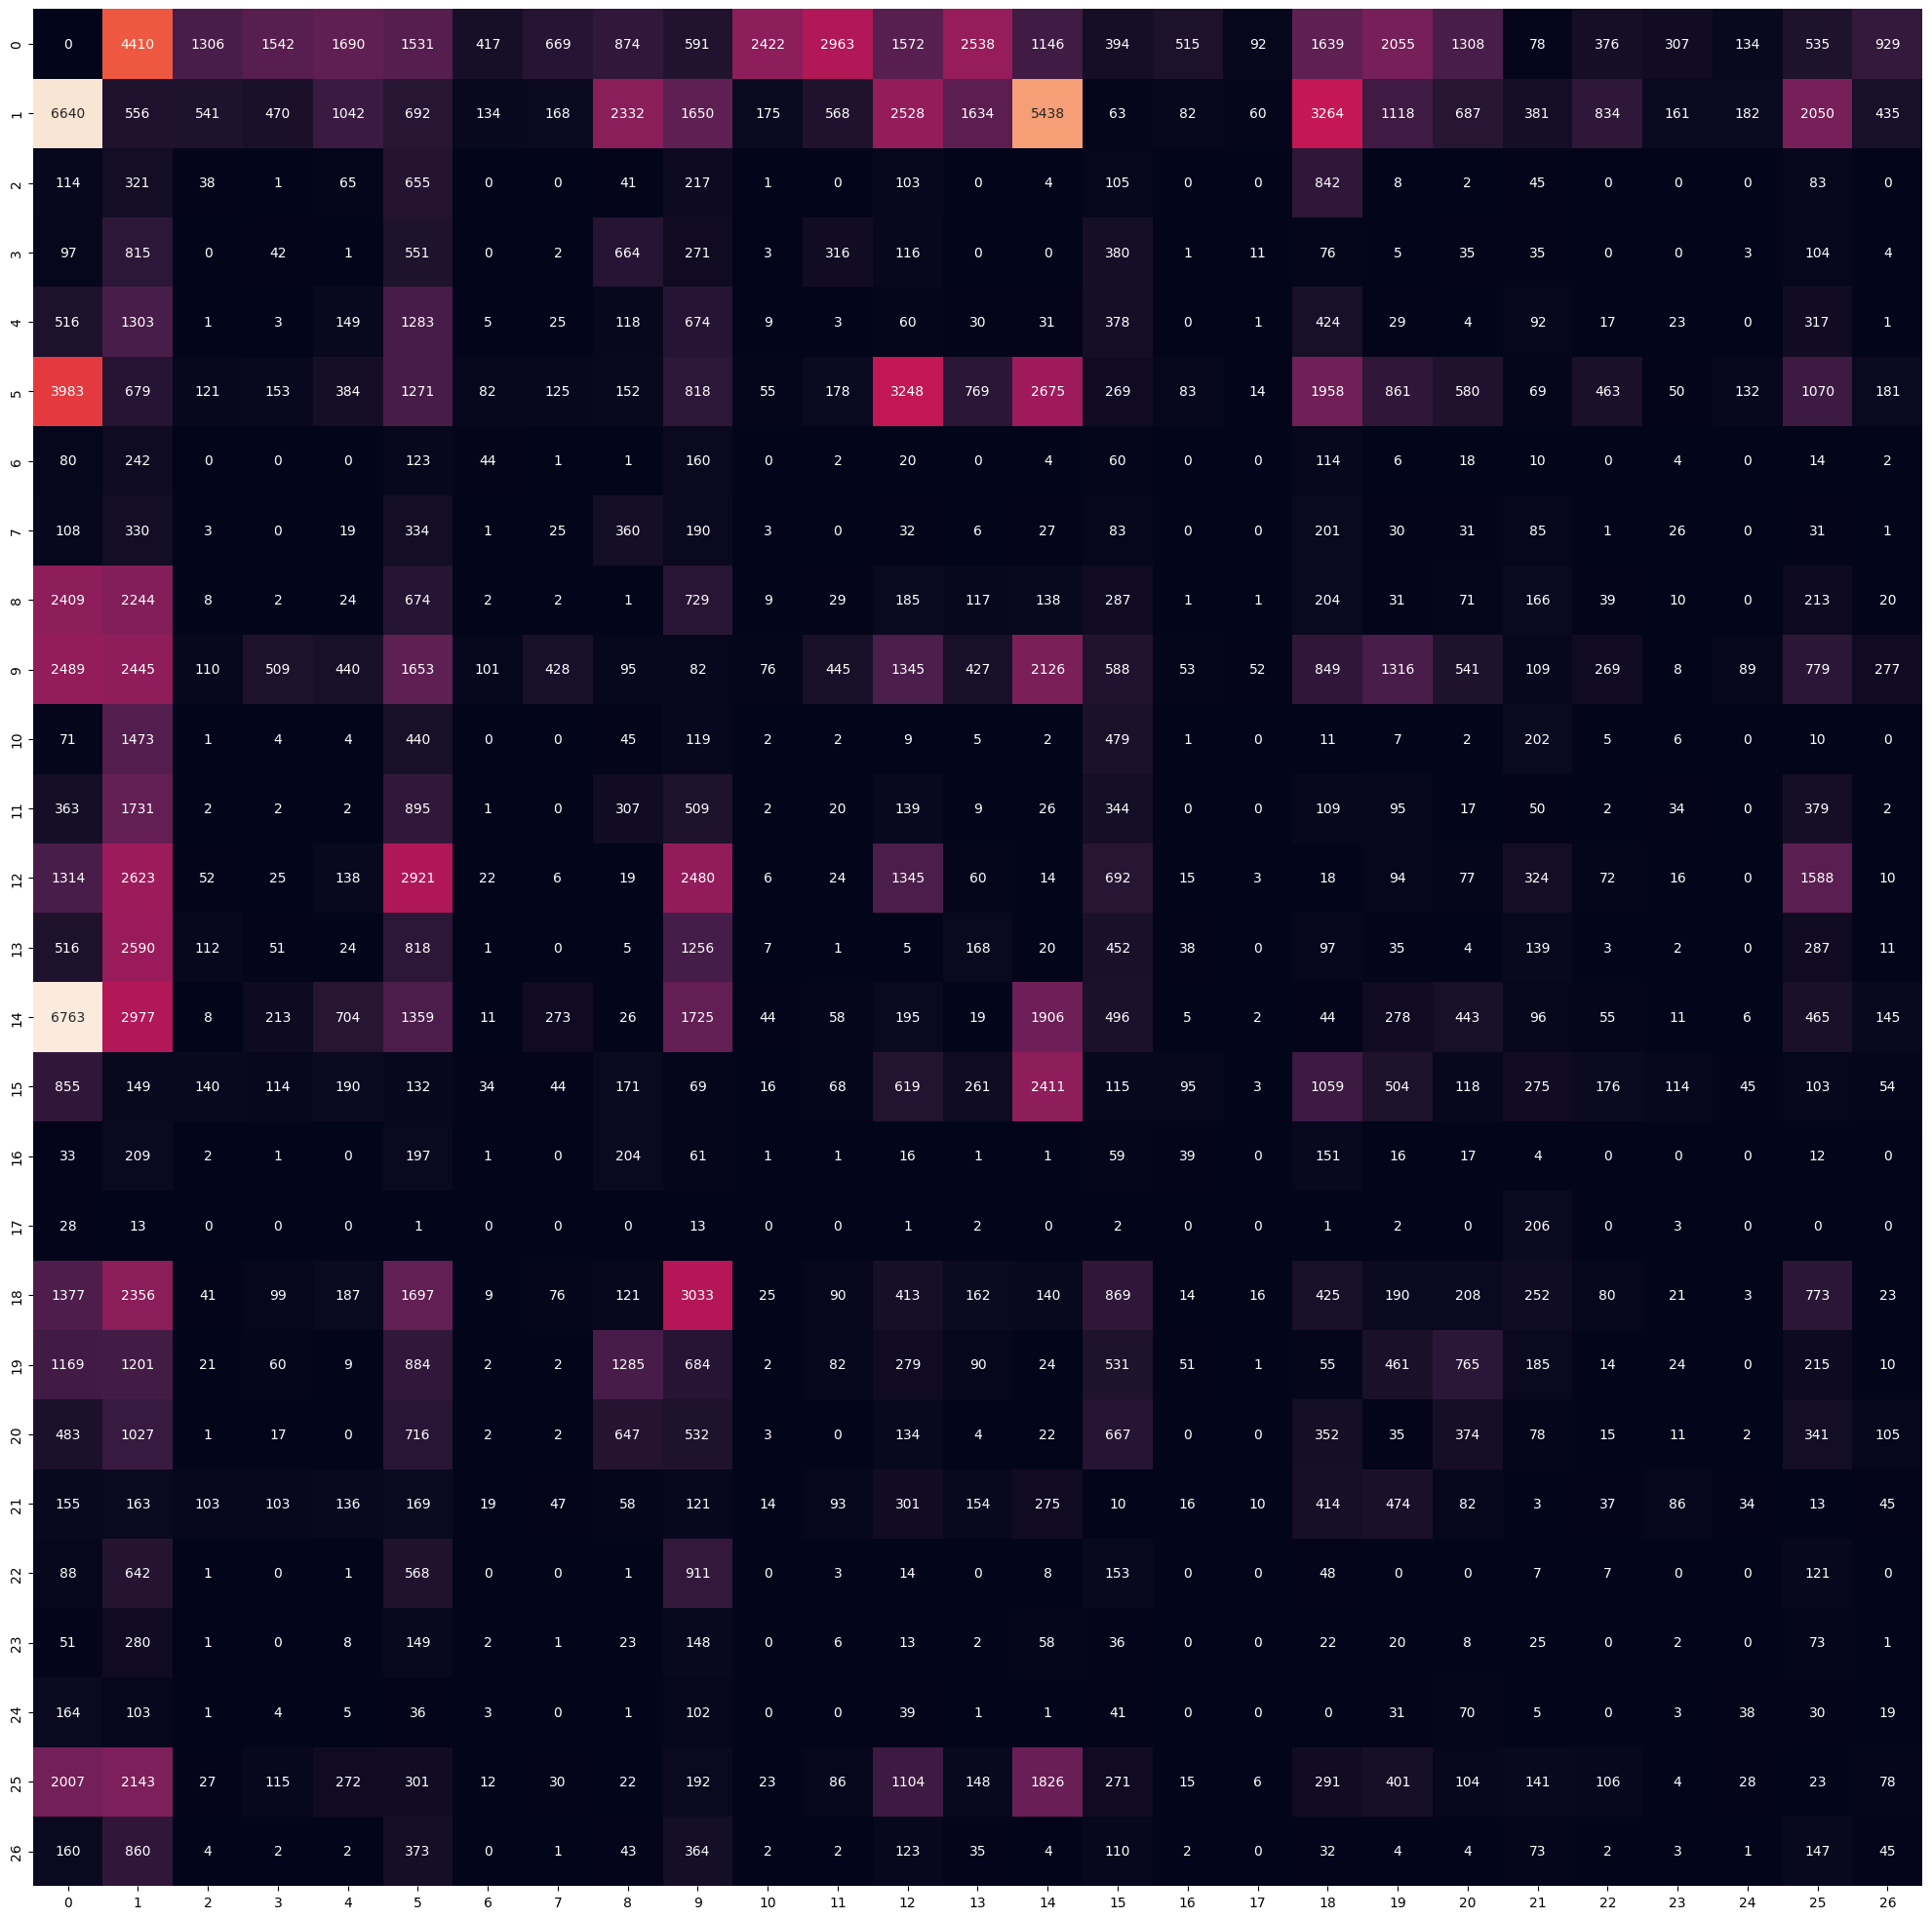

In [25]:
items = sorted(list(set([b for a, b in bigrams.keys()])))
pos_map = {v: k for k, v in enumerate(items)}
num_items = len(items)
t_bigrams = torch.zeros((num_items, num_items))
for name in names:
    ls = ["<T>"] + list(name.lower()) + ["<T>"]
    tpl = list(zip(ls, ls[1:]))
    for p1, p2 in tpl:
        t_bigrams[pos_map[p1], pos_map[p2]] += 1

# plot the tensor as a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(t_bigrams.numpy(), annot=True, fmt=".0f", cbar=False)

In [67]:
from typing import Union

# normalize by row
# t_bigrams = t_bigrams / t_bigrams.sum(dim=1, keepdim=True)
# NOTE: inplace operations tend to be faster
t_bigrams /= t_bigrams.sum(dim=1, keepdim=True)


def sample_next(p: Union[str, int]):
    if isinstance(p, str):
        p = pos_map[p]
    # retrieve probability distribution from tensor
    p = t_bigrams[p]
    # sample from the distribution
    return np.random.choice(items, p=p.numpy())


# pytorch variant of sample-next
def sample_next_pt(p: Union[str, int], model: torch.Tensor):
    if isinstance(p, str):
        p = pos_map[p]
    # sample from the distribution
    return torch.multinomial(model[p], 1).item()


def print_word(chars: int):
    last_char = "<T>"
    word = ""
    for _ in range(chars):
        last_char = sample_next(last_char)
        if last_char == "<T>":
            break
        word += last_char
    print(word)


num = 5

print("--- regular ---")
for i in range(num):
    print_word(100)

# pytorch variant of print-word
def print_word_pt(chars: int, model: torch.Tensor = t_bigrams):
    last_char = "<T>"
    word = ""
    for _ in range(chars):
        last_char = items[sample_next_pt(last_char, model)]
        if last_char == "<T>":
            break
        word += last_char
    print(word)


print("--- pytorch ---")
for i in range(num):
    print_word_pt(100)

print("--- uniform ---")
t_uni = torch.ones((num_items, num_items)) / num_items
for i in range(num):
    print_word_pt(100, t_uni)

--- regular ---
chidescivoylyaziowezi
ayaem
k
khimomonn
hahe
--- pytorch ---
werie
n
stfie
shylay
jan
--- uniform ---
zhimjmrpgrkshwmkjndihdmluukbedthkiqto
t
wqevqototrkxaernqfkvyoxspmhaukcvudgmcwnxp
cmpqomkxdqwluenctmffloxxoxcetrtkjozmyineguywrsfqqwqodhjgnbrcvjbpglpz
lozcipiqelhftqpewwbtnfoilvtqzdxnnjfuchthjgymwyozkutpuljrrgototmlemadsgambkjopzxospdkz


### Broadcasting Semantics

This is something one should be aware of - how data is stretched when the dimensions do not match.


In [83]:
# test of semantics in numpy
a = np.arange(16).reshape(4, 4)
b = np.arange(4)

print("--- numpy ---")
print(a)
print(b)

print(a + b)
b = b.reshape(4, 1)
print(a + b)

--- numpy ---
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[0 1 2 3]
[[ 0  2  4  6]
 [ 4  6  8 10]
 [ 8 10 12 14]
 [12 14 16 18]]
[[ 0  1  2  3]
 [ 5  6  7  8]
 [10 11 12 13]
 [15 16 17 18]]


In [85]:
ta = torch.arange(16).reshape(4, 4)
tb = torch.arange(4)

print("--- pytorch ---")
print(ta)
print(tb)

print(ta + tb)
tb = tb.reshape(4, 1)
print(ta + tb)

--- pytorch ---
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
tensor([0, 1, 2, 3])
tensor([[ 0,  2,  4,  6],
        [ 4,  6,  8, 10],
        [ 8, 10, 12, 14],
        [12, 14, 16, 18]])
tensor([[ 0,  1,  2,  3],
        [ 5,  6,  7,  8],
        [10, 11, 12, 13],
        [15, 16, 17, 18]])


As you can see the reshaping (adding of the 1 dimension, which defines the stratching direction) makes a difference in the calculation.

## Evaluation

Next step is to build an evaluation metric for the model performance. For this we will need to see how well the model adapted to the probabilities in our training set.


In [116]:
def get_prob(
    input: Union[str, int], pred: Union[str, int], model: torch.Tensor
) -> float:
    if isinstance(input, str):
        input = pos_map[input]
    if isinstance(pred, str):
        pred = pos_map[pred]
    return model[input, pred].item()


from typing import List

# generate bigrams from training
# randomly sample x names
test = np.random.choice(names, 100)


def compute_nll(model: torch.Tensor, test: List[str]):
    log_likelihood = 0
    n = 0
    for name in test:
        ls = ["<T>"] + list(name.lower()) + ["<T>"]
        tpl = list(zip(ls, ls[1:]))
        for bigram in tpl:
            p = get_prob(bigram[0], bigram[1], model)
            log_likelihood += np.log(p)
            n += 1

    return -log_likelihood / n


bigram_nll = compute_nll(t_bigrams, test)
uni_nll = compute_nll(t_uni, test)

print(f"Bigram NLL: {bigram_nll:.4f}")
print(f"Uniform NLL: {uni_nll:.4f}")

Bigram NLL: 2.5362
Uniform NLL: 3.2958


Note that in this case log probabilities are used, as they are easier to work with.
They are also just a monotonic transformation, so the learning problem stays the same.

## Train Neural Network

Next step is to build a neural network that learns from the data. For that we need:

1. Build a training dataset from which we can iterate
2. Build a model that can be trained
3. Build a loss function that can be used to train the model (NLL)
4. Provide both a train function and a validation function (+ a general predict function for serving)
5. Compare the performance of the model against the baseline (bigram model above)


In [195]:
from torch.nn import functional as F

# Build the training data
train = names[:30000]
test = names[30000:]

# build into a train and label data
def build_data(names: List[str]):
    train = []
    label = []
    for name in names:
        ls = ["<T>"] + list(name.lower()) + ["<T>"]
        tpl = list(zip(ls, ls[1:]))
        for bigram in tpl:
            train.append(pos_map[bigram[0]])
            label.append(pos_map[bigram[1]])

    # convert to tensors and expand as one-hots
    train = torch.tensor(train)
    label = torch.tensor(label)
    train = F.one_hot(train, num_items).float()
    label = F.one_hot(label, num_items).float()
    # cast to float 32

    return train, label


train_X, train_y = build_data(train)
test_X, test_y = build_data(test)

Now that we have training data, we want to build a pytorch model that can generate data from it. We start with a simple model build from scratch and running through the parameters manually.


Auto (2, 14) = -1.0742
Manual (2, 14) = -1.0742
torch.Size([5, 27])


tensor([[0.0320, 0.0148, 0.0983, 0.0320, 0.3079, 0.0159, 0.0508, 0.0039, 0.0018,
         0.0068, 0.0317, 0.0056, 0.0441, 0.0189, 0.0018, 0.0043, 0.0175, 0.1943,
         0.0058, 0.0243, 0.0037, 0.0358, 0.0028, 0.0286, 0.0018, 0.0038, 0.0109],
        [0.0983, 0.0327, 0.0440, 0.0099, 0.0431, 0.0231, 0.0159, 0.0038, 0.0096,
         0.0952, 0.0967, 0.0124, 0.0209, 0.0178, 0.0248, 0.0034, 0.0269, 0.3577,
         0.0065, 0.0138, 0.0014, 0.0234, 0.0015, 0.0072, 0.0024, 0.0013, 0.0063],
        [0.0373, 0.1135, 0.0833, 0.0050, 0.0225, 0.0044, 0.0351, 0.0045, 0.1072,
         0.0057, 0.0351, 0.0305, 0.0016, 0.0052, 0.0125, 0.0203, 0.0720, 0.0406,
         0.1100, 0.1761, 0.0013, 0.0280, 0.0036, 0.0289, 0.0073, 0.0075, 0.0010],
        [0.0373, 0.1135, 0.0833, 0.0050, 0.0225, 0.0044, 0.0351, 0.0045, 0.1072,
         0.0057, 0.0351, 0.0305, 0.0016, 0.0052, 0.0125, 0.0203, 0.0720, 0.0406,
         0.1100, 0.1761, 0.0013, 0.0280, 0.0036, 0.0289, 0.0073, 0.0075, 0.0010],
        [0.0547, 0.1211,

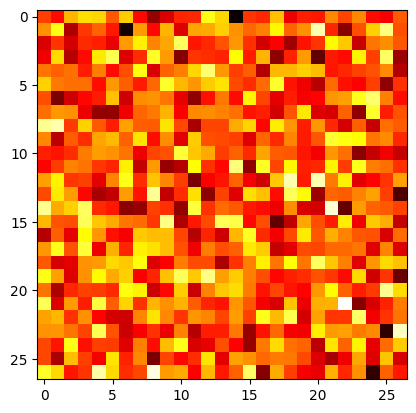

In [229]:
W1 = torch.randn((num_items, num_items), requires_grad=True)
bias = torch.randn((1, num_items), requires_grad=True)


def forward(X: torch.Tensor, W: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    logits = (X @ W) + b
    # softmax
    counts = logits.exp()
    return counts / counts.sum(dim=1, keepdim=True)


# visualize weights
plt.imshow(W1.detach().numpy(), cmap="hot")

# run on example data (do through matrix mul and through elementwise and then sum)
res = train_X[:10] @ W1
xpos = 2
ypos = 14
print(f"Auto ({xpos}, {ypos}) = {res[xpos, ypos]:.4f}")
print(f"Manual ({xpos}, {ypos}) = {(train_X[xpos, :] * W1[:, ypos]).sum():.4f}")

probs = forward(train_X[:5], W1, bias)
print(probs.shape)
probs

Next we want to compute the negative log-likelihoods. Likelihoods are probability that a sample is generated by a probability distribution. Therefore we need to take the actual correct value and check which probability it got assigned by the neural net.


In [214]:
def nll(
    X: torch.Tensor, y: torch.Tensor, W: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:
    probs = forward(X, W, b)
    lhood = (probs * y).sum(dim=1)
    # take mean to make usre large data is still handlable
    return -torch.log(lhood).mean()


# compute test nll
test_nll = nll(test_X, test_y, W1, bias)
print(f"Test NLL: {test_nll:.4f}")

Test NLL: 3.8727


Note here that this would also work when we are not using one-hot encodings, but actual probability distributions.

Next we can run through optimization loops:


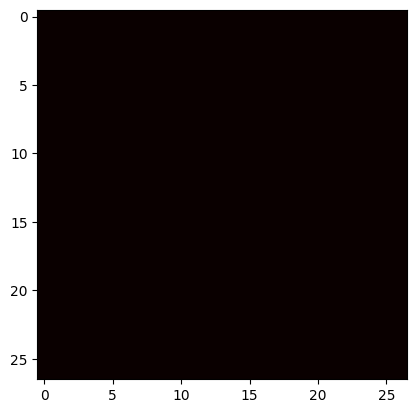

Step 1 Loss: 3.1201
Step 51 Loss: 3.0298


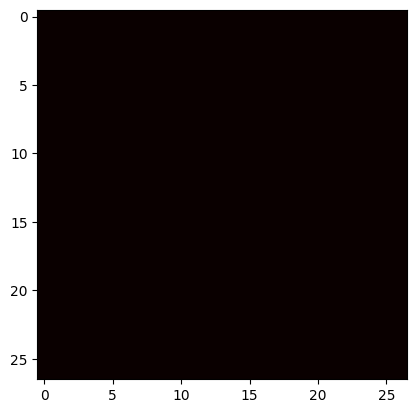

Step 101 Loss: 2.9721
Step 151 Loss: 2.9318


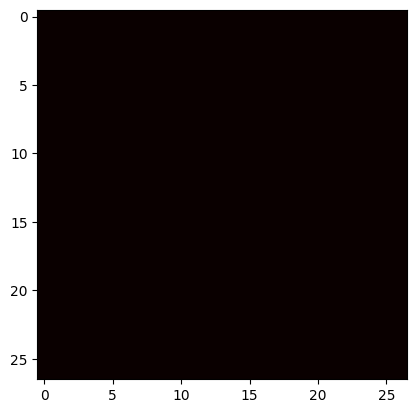

Step 201 Loss: 2.9015
Step 251 Loss: 2.8775


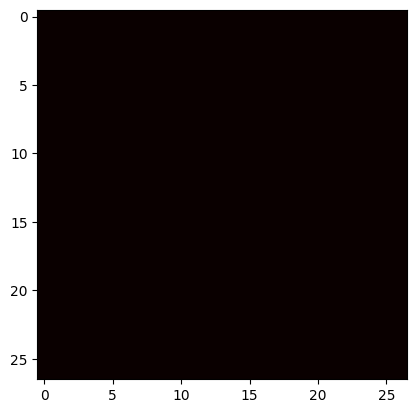

Step 301 Loss: 2.8576
Step 351 Loss: 2.8408


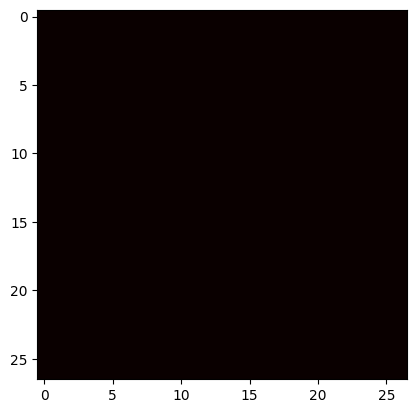

Step 401 Loss: 2.8261
Step 451 Loss: 2.8132


In [233]:
def train_step(
    X: torch.Tensor,
    y: torch.Tensor,
    W: torch.Tensor,
    b: torch.Tensor,
    W_last,
    lr: float = 0.1,
    show: bool = False,
):
    # forward pass
    probs = forward(X, W, b)
    # compute loss
    loss = nll(X, y, W, b)
    # compute gradients
    loss.backward()
    # update weights
    with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad

        # zero gradients
        W.grad.zero_()
        b.grad.zero_()

    # plot the weights
    if show:
        W_cur = torch.Tensor(W.detach().numpy())
        plt.imshow((W_cur - W_last) * 1000, cmap="hot")
        plt.show()

        W_last = W_cur

    return loss.item(), W_last


# train
W_last = torch.Tensor(W1.detach().numpy())
for i in range(500):
    loss, W_last = train_step(train_X, train_y, W1, bias, W_last, show=(i % 100 == 0))
    if i % 50 == 0:
        print(f"Step {i + 1} Loss: {loss:.4f}")

In [258]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self, num_items: int):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(num_items, num_items),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        probs = torch.softmax(logits, dim=1)
        return probs

    def predict(self, x):
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        logits = self.forward(x)
        return torch.argmax(logits, dim=1)

    def predict_proba(self, x):
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        logits = self.forward(x)
        return logits

    def sample_name(self, chars: int):
        pos = 0
        name = ""
        for _ in range(chars):
            one_hot = torch.nn.functional.one_hot(torch.tensor(pos), num_items).float()
            probs = self.predict_proba(one_hot)
            # sample position from probs
            pos = torch.multinomial(probs, 1).squeeze()
            if pos == 0:
                break
            name += items[pos.item()]
        return name


model = NeuralNetwork(num_items)
model.predict(test_X[:10])

tensor([ 9,  2, 13, 10, 25,  9,  2, 13, 25,  8])

In [257]:
def metric_nll(model, X, y) -> torch.Tensor:
    probs = model.forward(X)
    lhood = (probs * y).sum(dim=1)

    return -torch.log(lhood).mean()


print(metric_nll(model, test_X, test_y))

print("--- names ---")
for i in range(10):
    print(model.sample_name(100))

tensor(3.3173, grad_fn=<NegBackward0>)
--- names ---
glfiznacdbno
uovjygtvejgkyt
ndqplkjkexvutypzxqrfehonupojmrfwnqswaxjiphvjeugcjqjoqz
ymrtckakzgpyogmsmmqnplnubspscvujmxyrrkcogwekvhtlbstxuubynltekxnprn
oyj
mpkganwpytvbzegcztgcmhuyirbobjzsrzyqttydl
bssmeuclfcnxxvsd
gacjtukggi
znjwfnzpdrblgqkkoxhupfflijfob
cwamztkqgpkkoyqpjmdqhvcoinoivkszpgvkwcvzpahbomyckvocbknp


/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_14823/1390369602.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot = torch.nn.functional.one_hot(torch.tensor(pos), num_items).float()


Next we generate a training loop that can be used to train the model.


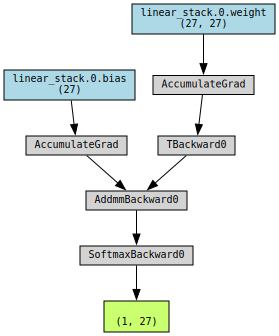

In [259]:
# print the model as dot
from torchviz import make_dot

make_dot(model.forward(test_X[:1]), params=dict(model.named_parameters()))

In [265]:
# generate opimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# train the model
def train_loop(model, optimizer, X, y, epochs=1, batch_size=5000):
    # compute test loss while freezing weights
    with torch.no_grad():
        loss = metric_nll(model, test_X, test_y)
    print(f"Epoch 0, Loss: {loss.item():.4f}")

    # iterate training
    for epoch in range(1, epochs + 1):
        for i in range(0, len(X), batch_size):
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            loss = metric_nll(model, X_batch, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            loss = metric_nll(model, test_X, test_y)
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


train_loop(model, optimizer, train_X, train_y, epochs=50)

Epoch 0, Loss: 2.5765
Epoch 1, Loss: 2.5765
Epoch 2, Loss: 2.5766
Epoch 3, Loss: 2.5766
Epoch 4, Loss: 2.5766
Epoch 5, Loss: 2.5766
Epoch 6, Loss: 2.5766
Epoch 7, Loss: 2.5766
Epoch 8, Loss: 2.5766
Epoch 9, Loss: 2.5766
Epoch 10, Loss: 2.5766
Epoch 11, Loss: 2.5767
Epoch 12, Loss: 2.5767
Epoch 13, Loss: 2.5767
Epoch 14, Loss: 2.5767
Epoch 15, Loss: 2.5767
Epoch 16, Loss: 2.5767
Epoch 17, Loss: 2.5767
Epoch 18, Loss: 2.5767
Epoch 19, Loss: 2.5767
Epoch 20, Loss: 2.5767
Epoch 21, Loss: 2.5768
Epoch 22, Loss: 2.5768
Epoch 23, Loss: 2.5768
Epoch 24, Loss: 2.5768
Epoch 25, Loss: 2.5768
Epoch 26, Loss: 2.5768
Epoch 27, Loss: 2.5768
Epoch 28, Loss: 2.5768
Epoch 29, Loss: 2.5768
Epoch 30, Loss: 2.5768
Epoch 31, Loss: 2.5769
Epoch 32, Loss: 2.5769
Epoch 33, Loss: 2.5769
Epoch 34, Loss: 2.5769
Epoch 35, Loss: 2.5769
Epoch 36, Loss: 2.5769
Epoch 37, Loss: 2.5769
Epoch 38, Loss: 2.5769
Epoch 39, Loss: 2.5769
Epoch 40, Loss: 2.5770
Epoch 41, Loss: 2.5770
Epoch 42, Loss: 2.5770
Epoch 43, Loss: 2.577

In [269]:
# regenerate names
print("--- names ---")
for i in range(10):
    print(model.sample_name(100))

--- names ---
fos
cae
sueke
asa
ahia
vondes
on
zamale
mo
as


/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_14823/1390369602.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot = torch.nn.functional.one_hot(torch.tensor(pos), num_items).float()


Next we want to build a model with dynamic input length data. For that we need to redefine two functions:

1. The network itself
2. The training data generation (to make sure we have n input samples)


In [381]:
def create_model(num_items: int, heads: int = 3, emb_size: int = 10):
    # map each input character to embedding size
    W1 = torch.randn(num_items, emb_size, requires_grad=True)
    b1 = torch.randn(emb_size, requires_grad=True)

    # map the concatenated embeddings to the output
    W2 = torch.randn(emb_size * heads, num_items, requires_grad=True)
    b2 = torch.randn(num_items, requires_grad=True)

    W3 = torch.randn(1024, num_items, requires_grad=True)
    b3 = torch.randn(num_items, requires_grad=True)

    return W1, b1, W2, b2, W3, b3


def build_data_heads(names: List[str], heads: int = 3):
    train = []
    label = []
    for name in names:
        ls = ["<T>"] * heads + list(name.lower()) + ["<T>"]
        tpl = list(zip(ls, *[ls[i + 1 :] for i in range(heads)]))
        for bigram in tpl:
            train.append([pos_map[i] for i in bigram[:-1]])
            label.append(pos_map[bigram[-1]])

    # convert to tensors and expand as one-hots
    train = torch.tensor(train)
    # train = F.one_hot(train, num_items)
    label = F.one_hot(torch.tensor(label), num_items)
    return train, label


# create model and train data
heads = 5
model = create_model(num_items, heads=heads, emb_size=2)
train_X3, train_y3 = build_data_heads(names[:30000], heads=heads)
test_X3, test_y3 = build_data_heads(names[30000:], heads=heads)

train_X3.shape, train_y3.shape

(torch.Size([213678, 5]), torch.Size([213678, 27]))

In [382]:
def forward_mlp(model, X, heads: int = 3):
    W1, b1, W2, b2, W3, b3 = model
    # add a dimension to W1 to ensure broadcasting
    # W1 = W1.unsqueeze(0)
    # embs = X @ W1 + b1
    # retrieve the embedding from matrix
    embs = W1[X]

    # concatenate the embeddings
    embs = embs.view(-1, W2.shape[0])

    # compute the hidden layer
    # hidden = embs @ W2 + b2
    hidden = torch.tanh(embs)

    # compute the logits
    logits = hidden @ W2 + b2
    probs = torch.softmax(logits, dim=1)
    return probs


def nll_mlp(X: torch.Tensor, y: torch.Tensor, model) -> torch.Tensor:
    probs = forward_mlp(model, X)
    lhood = (probs * y).sum(dim=1)
    # take mean to make usre large data is still handlable
    return -torch.log(lhood).mean()


forward_mlp(model, train_X3[:10], heads=heads).shape

torch.Size([10, 27])

In [384]:
# model = create_model(num_items, heads=3, emb_size=64)


def train_step_mlp(
    X: torch.Tensor, y: torch.Tensor, model, lr: float = 0.1, heads: int = 3
):
    # forward pass
    probs = forward_mlp(model, X, y)
    # compute loss
    loss = nll_mlp(X, y, model)
    # compute gradients
    loss.backward()
    # update weights
    W1, b1, W2, b2, W3, b3 = model
    with torch.no_grad():
        W1 -= lr * W1.grad
        # b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        # W3 -= lr * W3.grad
        # b3 -= lr * b3.grad

        # zero gradients
        W1.grad.zero_()
        # b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        # W3.grad.zero_()
        # b3.grad.zero_()

    return loss.item()


# train
with torch.no_grad():
    loss = nll_mlp(test_X3, test_y3, model)
print(f"Step 0 Test Loss: {loss:.4f}")
for i in range(300):
    loss = train_step_mlp(train_X3, train_y3, model, lr=5e-1, heads=heads)
    if i % 50 == 0:
        print(f"Step {i + 1} Loss: {loss:.4f}")

with torch.no_grad():
    loss = nll_mlp(test_X3, test_y3, model)
print(f"Final Test Loss: {loss:.4f}")

Step 0 Test Loss: 2.9925
Step 1 Loss: 2.8642
Step 51 Loss: 2.7630
Step 101 Loss: 2.7199
Step 151 Loss: 2.6918
Step 201 Loss: 2.6705
Step 251 Loss: 2.6531
Final Test Loss: 2.7638


(27, 2)
(27, 2)


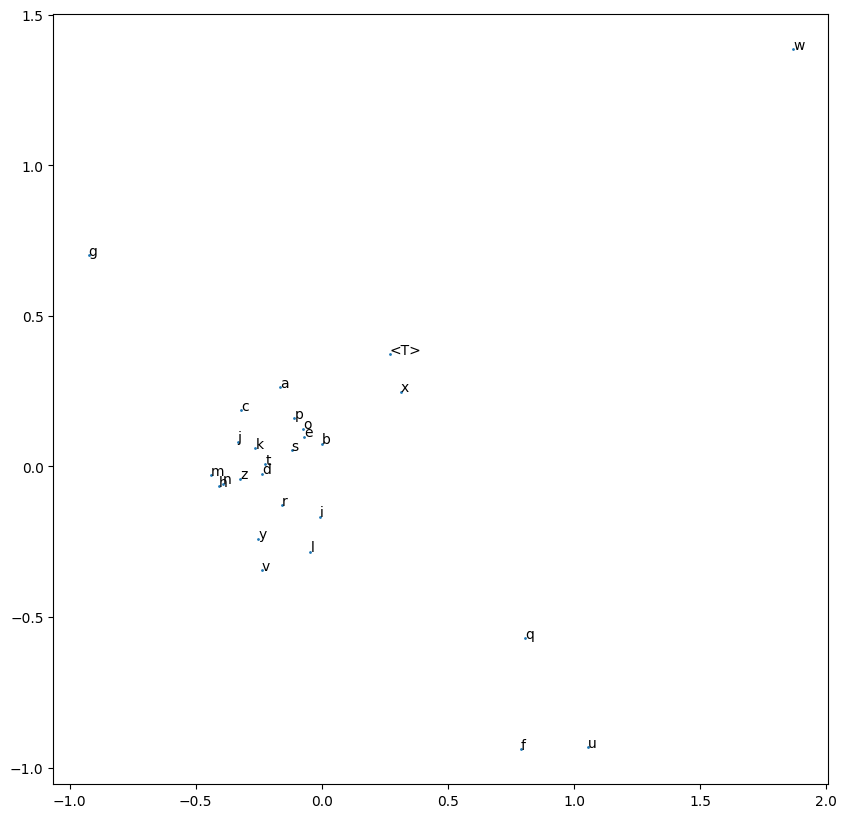

In [387]:
from sklearn.decomposition import PCA

emb_points = model[0].detach().numpy()
print(emb_points.shape)

# use PCA to reduce the dimensionality
pca = PCA(n_components=2)
emb_points = pca.fit_transform(emb_points)
print(emb_points.shape)

# plot the embedding points on a 2D plane
plt.figure(figsize=(10, 10))
# and label the points
plt.scatter(emb_points[:, 0], emb_points[:, 1], s=1)

# plot the labels
for i, label in enumerate(pos_map):
    plt.annotate(label, (emb_points[i, 0], emb_points[i, 1]), fontsize=10)
plt.show()

In [369]:
with torch.no_grad():
    loss = nll_mlp(test_X3, test_y3, model)
print(f"Final Test Loss: {loss:.4f}")

Final Test Loss: 3.6381


In [385]:
def sample_name_mlp(model, size, heads: int = 3):
    chars = [0] * heads
    word = ""
    for i in range(size):
        probs = forward_mlp(model, torch.tensor([chars]), heads=heads)
        # sample from the distribution
        sample = torch.multinomial(probs[0], 1, replacement=True).item()
        if sample == 0:
            break

        chars = chars[1:] + [sample]
        word += items[sample]
    return word


# sample names
print("--- names ---")
for i in range(10):
    print(sample_name_mlp(model, 100, heads=heads))

--- names ---
yaais
hyieoc
nolienh
aaalutny
znoa
girhn
v
egoyeaujtyv
rarerao
ymrin


## Competition

Reimplement the above network as a PyTorch Model and beat the test set performance of 2.17 NLL.


In [434]:
import random

# split names into 3 datasets (based on percentages)
train_perc, dev_perc, eval_perc = 0.8, 0.1, 0.1

# shuffle names
random.shuffle(names)

# split the names
train_names = names[: int(len(names) * train_perc)]
dev_names = names[
    int(len(names) * train_perc) : int(len(names) * (train_perc + dev_perc))
]
eval_names = names[int(len(names) * (train_perc + dev_perc)) :]

# print stats
print(f"Train: {len(train_names)}")
print(f"Dev: {len(dev_names)}")
print(f"Eval: {len(eval_names)}")

# define hparams
heads = 5
hidden_size = 1024
emb_size = 64
act = nn.Tanh()

Train: 25626
Dev: 3203
Eval: 3204


In [490]:
import collections

episode_list = [[0] + list(name) + [1] for item in names]
# define special chars
max_len = 1
vocab = {"<BOS>": 0, "<EOS>": 1, " ": 2}


def vocab_iter(ep_list, vocab):
    counts = collections.Counter()
    max_vocab = max([len(v) for v in vocab.keys()])
    for episode in ep_list:
        for i in range(max_vocab, 0):
            for pos in range(0, len(episode) - i + 1):
                item = episode[pos : pos + i]
                # check if matches
                if item in vocab:
                    replace


a1 = "Foo Bar Baz"
a2 = "<T0>Foo<T2>Bar<T2>Baz<T1>"
a3 = ["<T0>", "F", "o", "o", "<T2>", "B", "a", "r", "<T2>", "B", "a", "z", "<T1>"]
counts = collections.Counter(list(zip(a3, a3[1:])))
vocab = {"<BOS>": 0, "<EOS>": 1, " ": 2}
inv_vocab = {v: k for k, v in vocab.items()}


def update_vocab(token: str, vocab: dict):
    pos = len(vocab)
    vocab[token] = pos
    inv_vocab = {v: k for k, v in vocab.items()}
    return vocab, inv_vocab


# pick highest
char = counts.most_common(1)[0][0]
import re


def replTok(char: str, inv_vocab: dict):
    m = re.match(r"<T(\d+)>", char)
    if m is None:
        return char
    num = int(m.group(1))
    # return inverse
    return inv_vocab.get(num)


def replRes(char_set, inv_vocab):
    return "".join([replTok(char, inv_vocab) for char in char_set])


vocab, inv_vocab = update_vocab(replRes(char, inv_vocab), vocab)

# iterate data
a4 = ["<BOS>"] + list(a1) + ["<EOS>"]
# replace all vocab
len_vocab = list(vocab.keys())
len_vocab.sort(key=len, reverse=True)
a5 = list(a4)
for token in len_vocab:
    for i in range(len(a5) - len(token) + 1):
        data = "".join(a5[i : i + len(token)])
        if data == token:
            a5 = a5[:i] + [token] + a4[i + len(token) :]
a5


def count_repl(a6, vocab, inv_vocab):
    counts = collections.Counter(list(zip(a6, a6[1:])))
    max_val = counts.most_common(1)[0][1]
    char = counts.most_common(1)[0][0]
    return update_vocab(replRes(char, inv_vocab), vocab)


vocab, inv_vocab = count_repl(a5, vocab, inv_vocab)

{'<BOS>': 0, '<EOS>': 1, ' ': 2, ' B': 3, '<BOS>F': 4}

In [517]:
from typing import List, Callable, Tuple, Dict
import collections
import re


def char_encoding(name: str) -> List[int]:
    return [pos_map[i] for i in list(name.lower())]


def generate_byte_encoding(
    items: List[str], exit_count: int = 10
) -> Tuple[Dict[int, str], Callable[[str], List[int]]]:
    # create basic vocab
    vocab = {"<BOS>": 0, "<EOS>": 1, " ": 2}
    inv_vocab = {v: k for k, v in vocab.items()}

    # function to udpate the vocab
    def update_vocab(token: str, vocab: dict):
        pos = len(vocab)
        vocab[token] = pos
        inv_vocab = {v: k for k, v in vocab.items()}
        return vocab, inv_vocab

    def replTok(char_set: Tuple, inv_vocab: dict) -> str:
        for i, char in enumerate(char_set):
            m = re.match(r"<T(\d+)>", char)
            if m is None:
                continue
            num = int(m.group(1))
            # return inverse
            char_set[i] = inv_vocab.get(num)
        return "".join(char_set)

    # prepare the items
    items = [["<EOS>"] + list(item) + ["<BOS>"] for item in items]

    # iterate data
    while True:
        # replace all vocab
        len_vocab = list(vocab.keys())
        len_vocab.sort(key=len, reverse=True)
        counts = collections.Counter()

        for pos, item_toks in enumerate(items):
            # iterate through all vocabulary items and replace
            for voc_tok in len_vocab:
                for i in range(len(item_toks)):
                    data = "".join(item_toks[i : i + 2])
                    if data == voc_tok:
                        item_toks = item_toks[:i] + [voc_tok] + item_toks[i + 2 :]
            # update item and add to counts
            items[pos] = item_toks
            counts.update(list(zip(item_toks, item_toks[1:])))

        max_item = counts.most_common(1)[0] if len(counts) > 0 else None
        # check for exit condition
        if max_item is None or max_item[1] < exit_count:
            # add remaining
            rem = set([j for i in counts.keys() for j in i if j not in vocab])
            for r in rem:
                pos = len(vocab)
                vocab[r] = pos
            inv_vocab = {v: k for k, v in vocab.items()}
            break
        vocab, inv_vocab = update_vocab(replTok(max_item[0], inv_vocab), vocab)

    # create encoding func
    def encode(name: str) -> List[int]:
        # iterate while there is replace
        name = list(name.lower())
        while True:
            found = False
            for i in range(len(name) - 1):
                data = "".join(name[i : i + 2])
                if data in vocab:
                    name = name[:i] + [data] + name[i + 2 :]
                    found = True
            if not found:
                break
        # check for single length
        name = [vocab.get(i, i) for i in name]
        return name

    return inv_vocab, encode


# DEBUG: test case
v, enc = generate_byte_encoding(["hello", "world"], 2)
print(v)
# NOTE: the current tokenization approach is by far not fast enough and might habe some errors
# v, enc = generate_byte_encoding(names, 10)
# v

{0: '<BOS>', 1: '<EOS>', 2: ' ', 3: 'll', 4: 'r', 5: 'd', 6: 'w', 7: 'e', 8: 'l', 9: 'o', 10: 'h'}


In [518]:
num_mlp_items = len(pos_map)


def gen_dataset(items: List[str], encode: Callable[[str], List[int]], heads: int):
    train = []
    label = []
    for name in items:
        ls = [0] * heads + encode(name) + [0]
        tpl = list(zip(ls, *[ls[i + 1 :] for i in range(heads)]))
        for bigram in tpl:
            train.append(bigram[:-1])
            label.append(bigram[-1])

    # convert to tensors and expand as one-hots
    train = torch.tensor(train)
    label = F.one_hot(torch.tensor(label), num_items)
    return train, label


train_X, train_y = gen_dataset(train_names, char_encoding, heads=heads)
dev_X, dev_y = gen_dataset(dev_names, char_encoding, heads=heads)
eval_X, eval_y = gen_dataset(eval_names, char_encoding, heads=heads)
print(train_X.shape)
print(dev_X.shape)
print(eval_X.shape)

torch.Size([182362, 5])
torch.Size([22896, 5])
torch.Size([22888, 5])


torch.Size([10, 27])


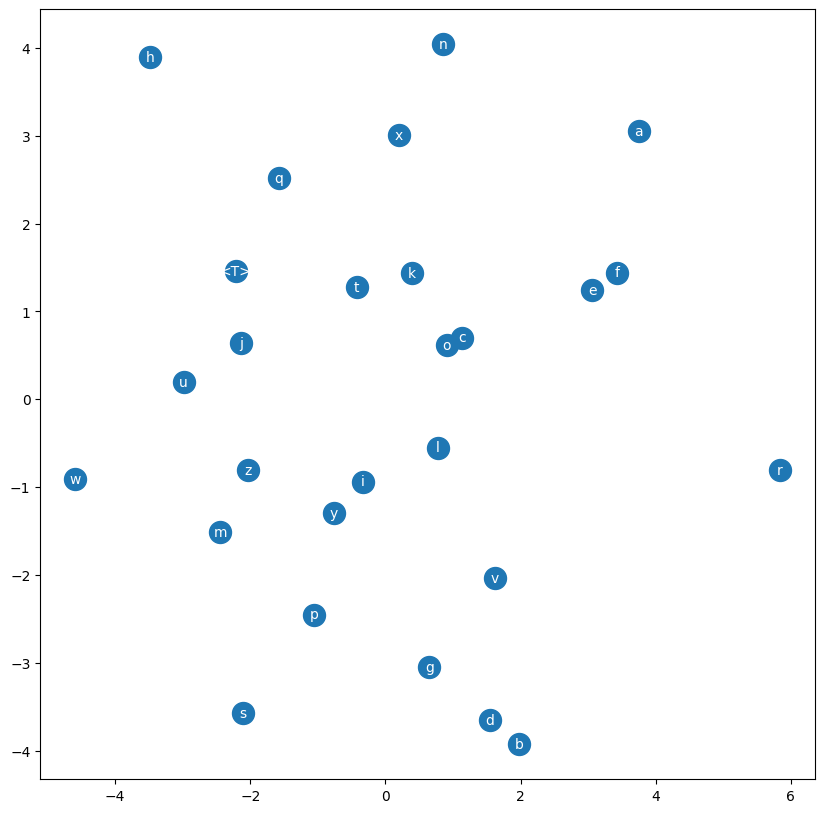

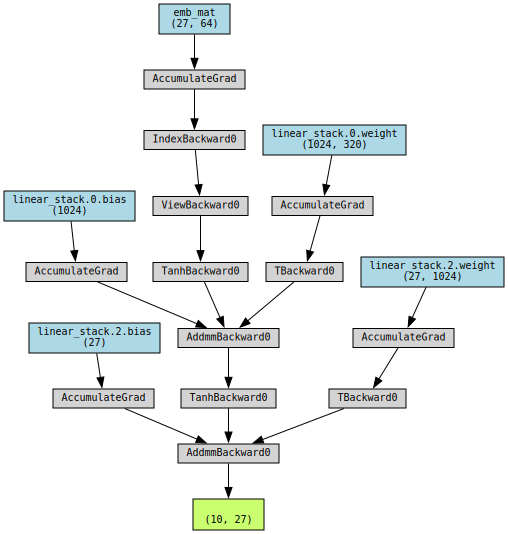

In [524]:
from torch import nn
from torchviz import make_dot
from typing import Dict
from sklearn.decomposition import PCA


class MLPNet(nn.Module):
    def __init__(
        self,
        char_map: Dict[int, str],
        num_items: int,
        emb_size: int = 64,
        hidden_size: int = 512,
        heads: int = 3,
        act: Callable[[torch.Tensor], torch.Tensor] = torch.tanh,
    ):
        super(MLPNet, self).__init__()
        self.heads = heads
        self.emb_size = emb_size
        self.act = act
        self.char_map = char_map

        # generate data
        self.emb_mat = nn.Parameter(
            torch.randn(num_items, emb_size, requires_grad=True)
        )
        # FEAT: add residual connections
        self.linear_stack = nn.Sequential(
            nn.Linear(heads * emb_size, hidden_size),
            self.act,
            nn.Linear(hidden_size, num_items),
        )

    def forward(self, x):
        # update the X (if out of shape)
        x = x.unqueeze(0) if len(x.shape) == 1 else x
        x = x.long()

        # retrieve embeddings and concat
        embs = self.emb_mat[x]
        embs = embs.view(-1, self.heads * self.emb_size)
        embs = self.act(embs)

        logits = self.linear_stack(embs)
        return logits

    def predict_proba(self, x):
        return torch.softmax(self.forward(x), dim=1)

    def predict(self, x):
        logits = self.predict_proba(x)
        return torch.argmax(logits, dim=1)

    def sample_word(self, size: int = 100) -> str:
        word = ""
        chars = [0] * self.heads
        for i in range(size):
            probs = self.predict_proba(torch.tensor([chars]))
            # sample from the distribution
            sample = torch.multinomial(probs[0], 1, replacement=True).item()
            if sample == 0:
                break

            chars = chars[1:] + [sample]
            word += self.char_map[sample]

        return word

    def plot_embeddings(self):
        emb_points = self.emb_mat.detach().numpy()

        # use PCA to reduce the dimensionality
        if emb_points.shape[1] > 2:
            pca = PCA(n_components=2)
            emb_points = pca.fit_transform(emb_points)

        # plot the embedding points on a 2D plane
        plt.figure(figsize=(10, 10))
        # and label the points
        plt.scatter(emb_points[:, 0], emb_points[:, 1], s=250)

        # plot the labels
        for i, label in enumerate(pos_map):
            plt.annotate(
                label,
                (emb_points[i, 0], emb_points[i, 1]),
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )
        plt.show()


# plots the given model
def plot_mlp(model, X=train_X):
    return make_dot(model.forward(X), params=dict(model.named_parameters()))


model = MLPNet(
    items,
    num_mlp_items,
    emb_size=emb_size,
    hidden_size=hidden_size,
    heads=heads,
    act=act,
)
# test forward path
print(model(train_X[:10]).shape)
model.plot_embeddings()
plot_mlp(model, train_X[:10])

In [525]:
# Testing the gradient distribution in the system
def print_grads(model):
    def grad_mean(grad):
        return grad.mean() if grad is not None else None

    print(f"emb: {grad_mean(model.emb_mat.grad)}")
    print(f"l1 weights: {grad_mean(model.linear_stack[0].weight.grad)}")
    print(f"l1 bias: {grad_mean(model.linear_stack[0].bias.grad)}")
    print(f"l2 weights: {grad_mean(model.linear_stack[2].weight.grad)}")
    print(f"l2 bias: {grad_mean(model.linear_stack[2].bias.grad)}")


# test the gradient
print("--- before ---")
print_grads(model)

print("--- after ---")
loss = F.cross_entropy(model(train_X[:10]), torch.argmax(train_y[:10], dim=1))
loss.backward()
print_grads(model)

--- before ---
emb: None
l1 weights: None
l1 bias: None
l2 weights: None
l2 bias: None
--- after ---
emb: 5.41061990588787e-06
l1 weights: -6.439658136514481e-06
l1 bias: -0.00010507776460144669
l2 weights: 8.454932066970233e-12
l2 bias: -5.518948631433318e-10


In [526]:
# test the adjustment of weights
def print_means(model):
    print(f"emb: {model.emb_mat.mean()}")
    print(f"l1 weights: {model.linear_stack[0].weight.mean()}")
    print(f"l1 bias: {model.linear_stack[0].bias.mean()}")
    print(f"l2 weights: {model.linear_stack[2].weight.mean()}")
    print(f"l2 bias: {model.linear_stack[2].bias.mean()}")


print("--- before ---")
print_means(model)

print("--- after ---")
loss = F.cross_entropy(model(train_X[:10]), torch.argmax(train_y[:10], dim=1))
loss.backward()
with torch.no_grad():
    for param in model.parameters():
        param -= 1 * param.grad
print_means(model)

--- before ---
emb: 0.006596297957003117
l1 weights: -4.829590761801228e-05
l1 bias: 0.0003816145472228527
l2 weights: 7.785434718243778e-05
l2 bias: -0.0068670641630887985
--- after ---
emb: 0.006585477851331234
l1 weights: -3.5416585888015106e-05
l1 bias: 0.000591769814491272
l2 weights: 7.785434718243778e-05
l2 bias: -0.006867061834782362


Next step now is to create a training loop that will also plot losses


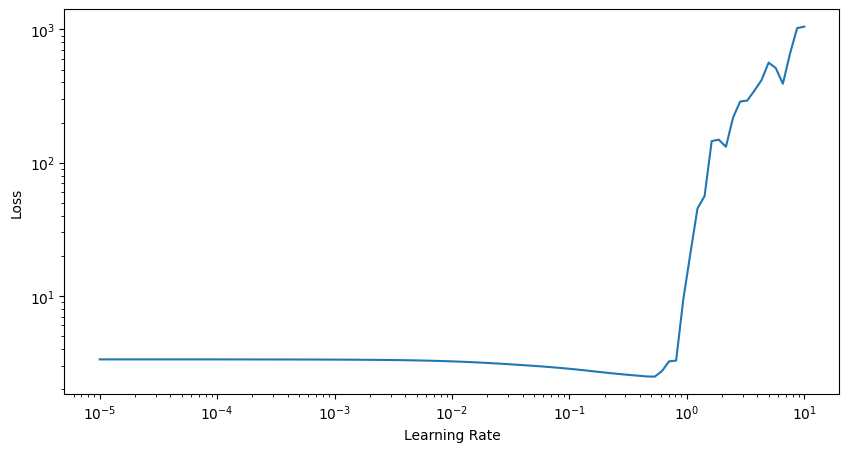

In [450]:
def train_epoch(model, train_X, train_y, lr: float = 1e-5, batch_size: int = 5000):
    batch_loss = []
    # shuffle the data
    idx = torch.randperm(train_X.shape[0])
    train_X = train_X[idx]
    train_y = train_y[idx]

    # train the model
    for i in range(0, train_X.shape[0], batch_size):
        # get the batch
        X = train_X[i : i + batch_size]
        y = train_y[i : i + batch_size]

        # compute the loss
        logits = model(X)
        loss = F.cross_entropy(logits, torch.argmax(y, dim=1))
        batch_loss += [loss.item()]

        # update the model
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

    return batch_loss


def compute_nll(model, X, y):
    # compute the loss
    probs = model.predict_proba(X)
    lhood = (probs * y).sum(dim=1)
    # take mean to make usre large data is still handlable
    return -torch.log(lhood).mean()


def optimize_step(model, train_X, train_y, test_X, test_y, lr=1e-5, batch_size=5000):
    batch_loss = train_epoch(model, train_X, train_y, lr=lr, batch_size=batch_size)
    with torch.no_grad():
        train_loss = compute_nll(model, train_X, train_y)
        test_loss = compute_nll(model, test_X, test_y)

    return train_loss, test_loss, batch_loss


# search and plot different learning rates
def grid_search(model, steps=100, batch_size=5000):
    # create a lin space of learning rates
    lrs = np.logspace(-5, 1, 100)
    train_losses = []

    for i, lr in enumerate(lrs):
        X = train_X[i : i + batch_size]
        y = train_y[i : i + batch_size]
        # compute the loss
        logits = model(X)
        loss = F.cross_entropy(logits, torch.argmax(y, dim=1))
        train_losses += [loss.item()]

        # update the model
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

    # plot data
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, train_losses)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.show()


# TODO: run grid search
grid_search(model)

Epoch 0: train loss 2.1596, test loss 2.1693 - Avg time 4.7467 sec
Epoch 10: train loss 2.1577, test loss 2.1676 - Avg time 4.7899 sec


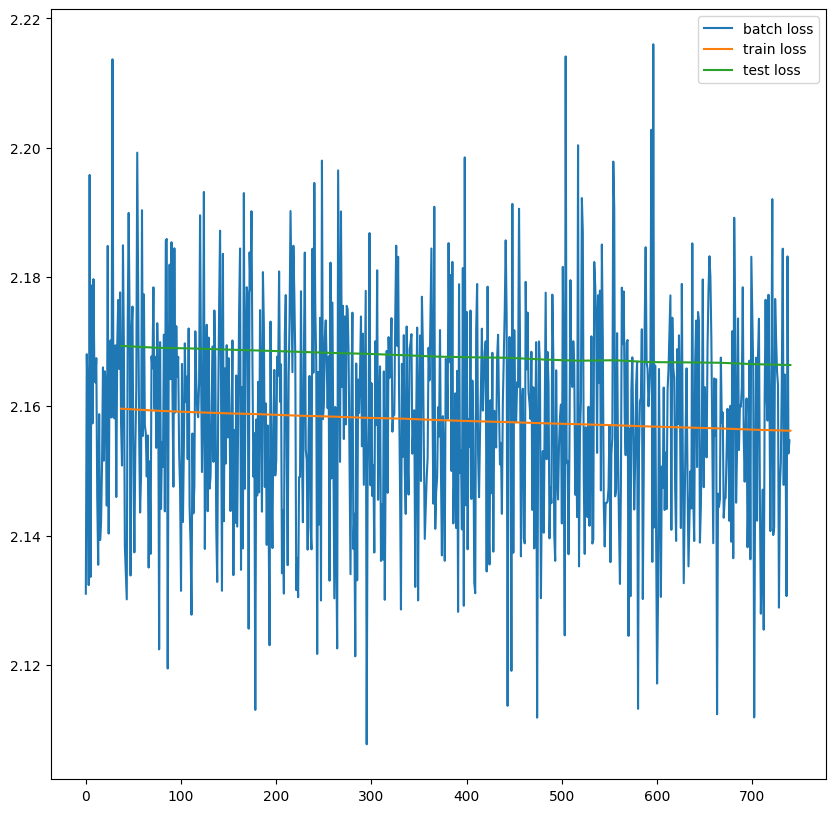

Final train loss: 2.1562, test loss: 2.1664


In [534]:
from time import time

# main optimization loop
train_loss = []
test_loss = []
epoch_steps = []
batch_loss = []
timings = []
for i in range(20):
    time_start = time()
    train_loss_, test_loss_, batch_loss_ = optimize_step(
        model, train_X, train_y, eval_X, eval_y, lr=1e-2, batch_size=5000
    )
    timings.append(time() - time_start)
    train_loss += [train_loss_]
    test_loss += [test_loss_]
    batch_loss += batch_loss_
    start_step = epoch_steps[-1] if epoch_steps else 0
    epoch_steps += [start_step + len(batch_loss_)]
    if i % 10 == 0:
        print(
            f"Epoch {i}: train loss {train_loss_:.4f}, test loss {test_loss_:.4f} - Avg time {np.mean(timings):.4f} sec"
        )

# plot the losses
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(batch_loss)), batch_loss, label="batch loss")
plt.plot(epoch_steps, train_loss, label="train loss")
plt.plot(epoch_steps, test_loss, label="test loss")
plt.legend()
plt.show()

# compute final loss
with torch.no_grad():
    train_loss = compute_nll(model, train_X, train_y)
    test_loss = compute_nll(model, eval_X, eval_y)
    print(f"Final train loss: {train_loss:.4f}, test loss: {test_loss:.4f}")

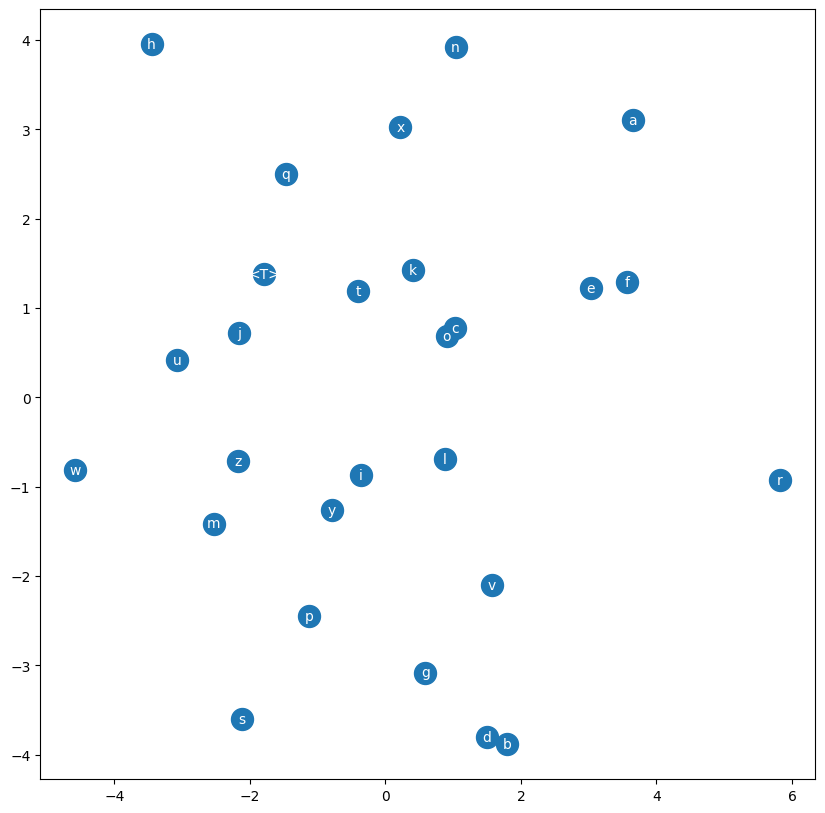

kingiaj
lemphbeld
ajuse
ricllyne
rabis
ajvizraden
jmrin
bsintij
ropalyni
raileye


In [535]:
model.plot_embeddings()
for i in range(10):
    print(model.sample_word())

In [538]:
# List number of parameters
def count_parameters(model):
    # sum number of elements in all model parameters that take a gradient
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Number of parameters: {count_parameters(model)}")

Number of parameters: 358107
